In [1]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np

path = 'data/'
ox.settings.useful_tags_node = ['name']

In [2]:
G2 = ox.graph_from_file(path+'Rostov3.osm', retain_all=False, simplify=False)

In [3]:
df_nodes = pd.DataFrame(dict(G2.nodes(data=True))).T

target_map = {
    r'.*(?i)клиника.*' : 'больница',
    r'.*(?i)больница.*' : 'больница',
    r'.*(?i)лицей.*' : 'школа',
    r'.*(?i)школа.*' : 'школа',
    r'.*(?i)гимназия.*' : 'школа',
    r'.*(?i)магазин.*' : 'магазин',
    r'.*(?i)универсам.*' : 'магазин',
}

df_nodes = df_nodes.replace({'name' : target_map}, regex=True)

In [4]:
df_obj = df_nodes[df_nodes['name'].isin(['больница', 'школа', 'магазин'])]
G2_simp = ox.simplify.simplify_graph(G2)

In [5]:
for simp_path in ox.simplify.get_paths_to_simplify(G2):
    for osmid in simp_path:
        argwhere = np.argwhere(df_obj['osmid'].to_numpy() == osmid)
        if argwhere.size > 0 and osmid not in list(G2_simp.nodes):
            i = argwhere[0][0]
            obj_node = df_obj.iloc[i].to_dict()
            G2_simp.add_node(osmid, **obj_node)
            G2_simp.add_edge(simp_path[0], osmid)
            G2_simp.add_edge(osmid, simp_path[-1])

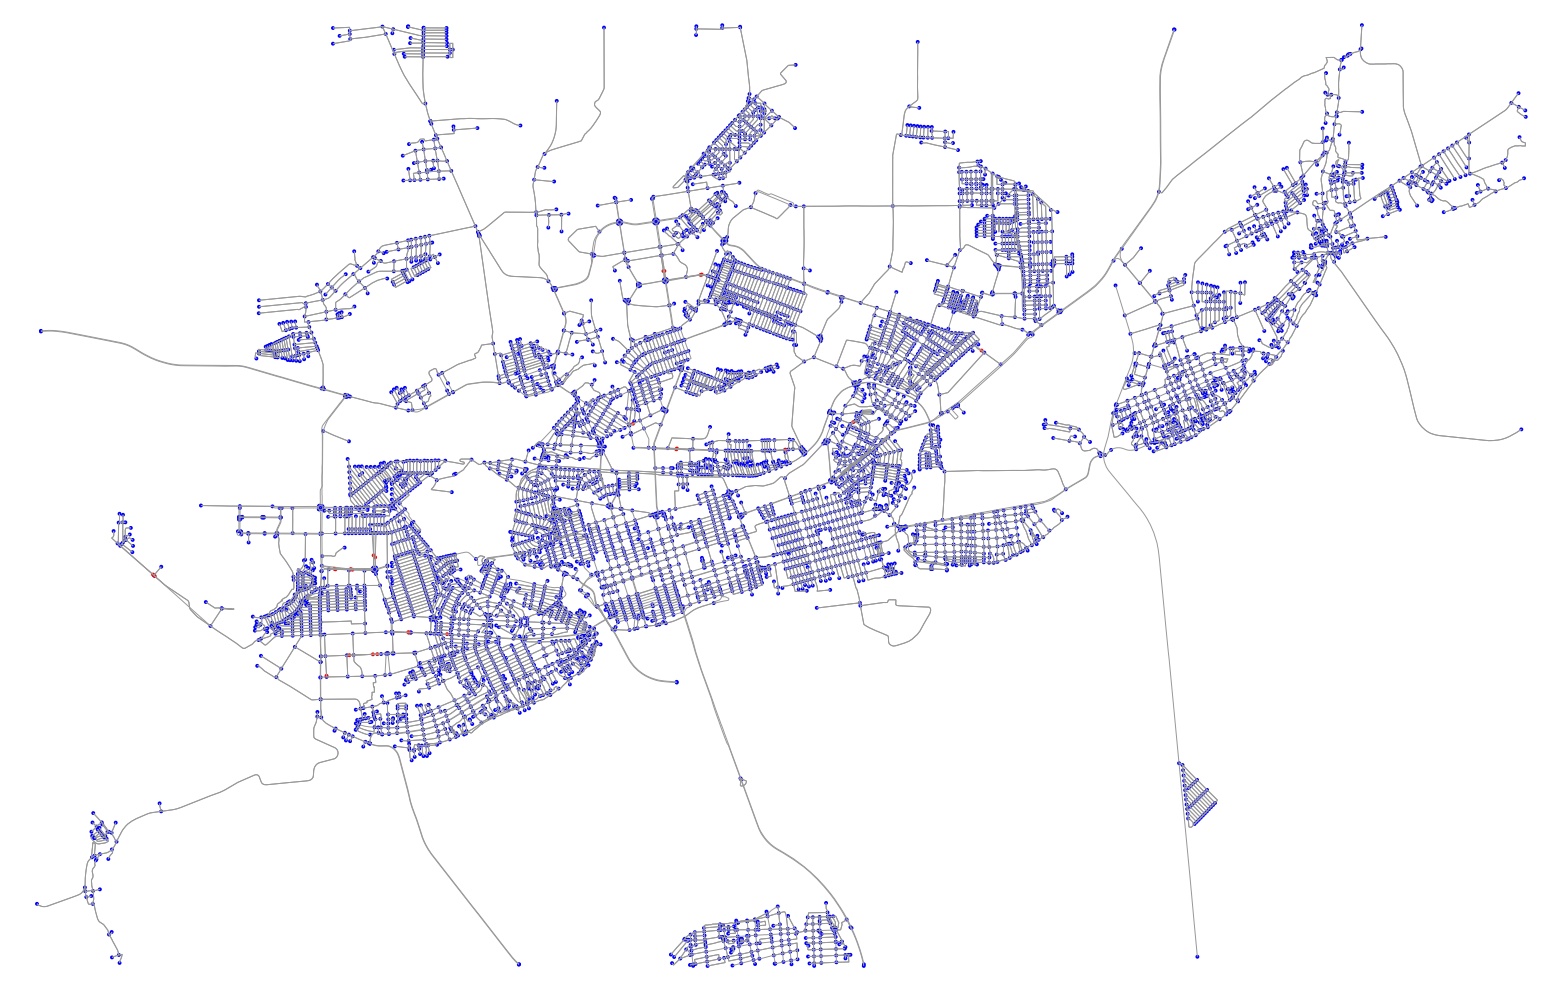

In [6]:
nc = ['r' if len(df_obj[df_obj['osmid'] == osmid]) > 0 else 'b' for osmid in G2_simp.nodes()]
fig, ax = ox.plot_graph(G2_simp, node_color = nc, fig_height=18)

In [7]:
df_matrix = nx.to_pandas_adjacency(G2_simp, dtype=np.uint8)

df_matrix.to_csv(path+'Adj_matrix_bbike_map.csv', index=False)

In [8]:
adj_list = list(nx.generate_adjlist(G2_simp))
df_list = pd.DataFrame(adj_list, columns = ['row'])
df_list = pd.DataFrame(df_list.row.str.split(' ').tolist())
df_list = df_list.rename(columns={0: 'Source'})

df_list.to_csv(path+'Adj_list_bbike_map.csv', index=False)

In [9]:
df_nodes_simp = pd.DataFrame(dict(G2_simp.nodes(data=True))).T

df_nodes_simp = df_nodes_simp.replace({'name' : target_map}, regex=True)
df_nodes_simp.loc[~df_nodes_simp['name'].isin(['больница', 'школа', 'магазин']), 'name'] = 'нет'

df_nodes_simp.to_csv(path+'Nodes_bbike_map.csv', index=False)